In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import pickle  
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
import time
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import load_model
from tensorflow.keras import Model, Input
import os
from sklearn.metrics import (
    roc_curve, precision_recall_curve,
    average_precision_score, roc_auc_score
)
from sklearn.preprocessing import OneHotEncoder

# 固定所有随机种子
np.random.seed(42)  
tf.random.set_seed(42) 

In [79]:
# 1.加载MNIST数据
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = mnist.load_data()
print(f"训练集图像：{x_train_raw.shape}")
print(f"训练集标签：{y_train_raw.shape}")
print(f"测试集图像：{x_test_raw.shape}")
print(f"测试集标签：{y_test_raw.shape}")

训练集图像：(60000, 28, 28)
训练集标签：(60000,)
测试集图像：(10000, 28, 28)
测试集标签：(10000,)


In [ ]:
# 2.数据质量检查

# 检查数据类型
print("\n1 数据类型检查：")
print(f"训练集图像类型：{x_train_raw.dtype}")
print(f"测试集图像类型：{x_test_raw.dtype}")
print(f"训练集标签类型：{y_train_raw.dtype}")
print(f"测试集标签类型：{y_test_raw.dtype}")

# 检查是否存在缺失值
print("\n2 缺失值检查：")
has_nan_train = np.isnan(x_train_raw).any()
has_nan_test = np.isnan(x_test_raw).any()
print(f"训练集缺失值情况：{has_nan_train}")
print(f"测试集缺失值情况：{has_nan_test}")

# 检查像素值范围
print("\n3 像素值范围检查：")
train_min, train_max = x_train_raw.min(), x_train_raw.max()
test_min, test_max = x_test_raw.min(), x_test_raw.max()
print(f"训练集像素值范围：[{train_min}, {train_max}]")
print(f"测试集像素值范围：[{test_min}, {test_max}]")

# 检查标签有效性
print("\n4 标签有效性检查：")
train_labels = np.unique(y_train_raw)
test_labels = np.unique(y_test_raw)
print(f"训练集标签：{train_labels}")
print(f"测试集标签：{test_labels}")
print(f"训练集标签是否全部有效：{np.array_equal(train_labels, np.arange(10))}")
print(f"测试集标签是否全部有效：{np.array_equal(test_labels, np.arange(10))}")

# 检查异常样本
print("\n5 异常样本检查：")
train_black = np.sum(x_train_raw.reshape(-1, 28*28).sum(axis=1) == 0)
test_black = np.sum(x_test_raw.reshape(-1, 28*28).sum(axis=1) == 0)
print(f"训练集全黑图像数量：{train_black}")
print(f"测试集全黑图像数量：{test_black}")


1 数据类型检查：
训练集图像类型：uint8
测试集图像类型：uint8
训练集标签类型：uint8
测试集标签类型：uint8

2 缺失值检查：
训练集缺失值情况：False
测试集缺失值情况：False

3 像素值范围检查：
训练集像素值范围：[0, 255]
测试集像素值范围：[0, 255]

4 标签有效性检查：
训练集标签：[0 1 2 3 4 5 6 7 8 9]
测试集标签：[0 1 2 3 4 5 6 7 8 9]
训练集标签是否全部有效：True
测试集标签是否全部有效：True

5 异常样本检查：
训练集全黑图像数量：0
测试集全黑图像数量：0


In [81]:
# 3. 数据预处理

def preprocess_mnist(x_train, x_test, y_train, y_test):
    # 拆分训练集验证集
    x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
        x_train, y_train, test_size=6000, random_state=42, stratify=y_train
    )
    # 灰度归一化
    x_train_split = x_train_split / 255.0
    x_val_split = x_val_split / 255.0
    x_test = x_test / 255.0  
    
    # KNN：展平为784维向量
    x_train_flat = x_train_split.reshape(-1, 28*28)  
    x_val_flat = x_val_split.reshape(-1, 28*28)      
    x_test_flat = x_test.reshape(-1, 28*28)         
    
    # CNN：添加通道数
    x_train_cnn = x_train_split.reshape(-1, 28, 28, 1)  
    x_val_cnn = x_val_split.reshape(-1, 28, 28, 1)      
    x_test_cnn = x_test.reshape(-1, 28, 28, 1)          
    
    return (x_train_flat, x_val_flat, x_test_flat,
            x_train_cnn, x_val_cnn, x_test_cnn,
            y_train_split, y_val_split, y_test)

(
    x_train_flat, x_val_flat, x_test_flat,  
    x_train_cnn, x_val_cnn, x_test_cnn,     
    y_train, y_val, y_test                  
) = preprocess_mnist(x_train_raw, x_test_raw, y_train_raw, y_test_raw)

# 保存预处理后的数据
np.savez(
    "mnist_preprocessed.npz",  
    x_train_flat=x_train_flat,
    x_val_flat=x_val_flat,
    x_test_flat=x_test_flat,
    x_train_cnn=x_train_cnn,
    x_val_cnn=x_val_cnn,
    x_test_cnn=x_test_cnn,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test
)

print(f"KNN训练集：{x_train_flat.shape}，CNN训练集：{x_train_cnn.shape}")
print(f"验证集样本数：{x_val_flat.shape[0]}，测试集样本数：{x_test_flat.shape[0]}")
print(f"标签样本数：训练集{y_train.shape}，验证集{y_val.shape}，测试集{y_test.shape}")

KNN训练集：(54000, 784)，CNN训练集：(54000, 28, 28, 1)
验证集样本数：6000，测试集样本数：10000
标签样本数：训练集(54000,)，验证集(6000,)，测试集(10000,)


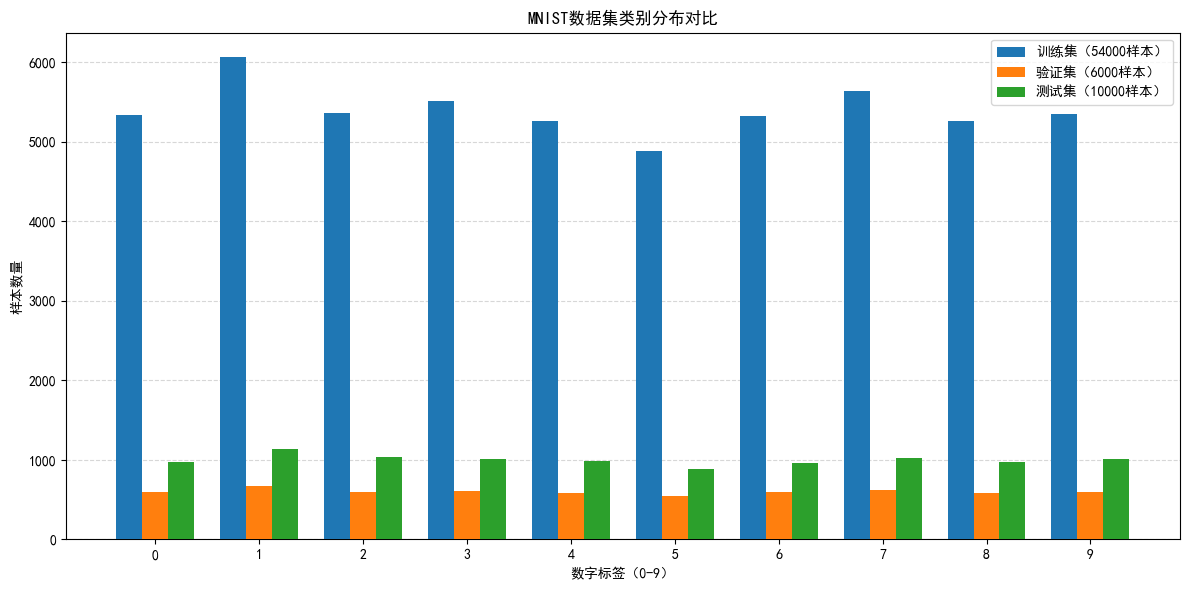

训练集每类样本数： [5331 6068 5362 5518 5258 4879 5326 5638 5266 5354]
验证集每类样本数： [592 674 596 613 584 542 592 627 585 595]
测试集每类样本数： [ 980 1135 1032 1010  982  892  958 1028  974 1009]


In [82]:
# 4. 训练集、验证集、测试集的类别分布

plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False 

with np.load("mnist_preprocessed.npz", allow_pickle=True) as data:
    y_train = data["y_train"]
    y_val = data["y_val"]
    y_test = data["y_test"]

# 统计类别分布
train_dist = np.bincount(y_train)
val_dist = np.bincount(y_val)
test_dist = np.bincount(y_test)

plt.figure(figsize=(12, 6))
plt.bar(range(10), train_dist, width=0.25, label="训练集（54000样本）", color="#1f77b4", zorder=3)
plt.bar(np.arange(10) + 0.25, val_dist, width=0.25, label="验证集（6000样本）", color="#ff7f0e", zorder=3)
plt.bar(np.arange(10) + 0.5, test_dist, width=0.25, label="测试集（10000样本）", color="#2ca02c", zorder=3)

plt.title("MNIST数据集类别分布对比")
plt.xlabel("数字标签（0-9）")
plt.ylabel("样本数量")
plt.xticks(np.arange(10) + 0.25, range(10))
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5, zorder=0)
plt.tight_layout()
plt.savefig("类别分布整合图.png", dpi=300, bbox_inches="tight")
plt.show()

print("训练集每类样本数：", train_dist)
print("验证集每类样本数：", val_dist)
print("测试集每类样本数：", test_dist)

In [ ]:
# 5. DummyClassifier基准模型

with np.load("mnist_preprocessed.npz", allow_pickle=True) as data:
    x_train_flat = data["x_train_flat"]
    x_test_flat = data["x_test_flat"]
    y_train = data["y_train"]
    y_test = data["y_test"]
    y_val = data["y_val"]

dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(x_train_flat, y_train)  

dummy_train_acc = accuracy_score(y_train, dummy.predict(x_train_flat))
dummy_val_acc = accuracy_score(y_val, dummy.predict(x_val_flat))
dummy_test_acc = accuracy_score(y_test, dummy.predict(x_test_flat))
dummy_f1 = f1_score(y_test, dummy.predict(x_test_flat), average="macro")

print(f"DummyClassifier 训练准确率：{dummy_train_acc:.1%}")
print(f"DummyClassifier 验证准确率：{dummy_val_acc:.1%}")
print(f"DummyClassifier 测试准确率：{dummy_test_acc:.1%}")
print(f"DummyClassifier 宏平均F1：{dummy_f1:.2f}")

# 保存结果
np.savez(
    "dummy_results.npz",
    train_acc=dummy_train_acc,
    val_acc=dummy_val_acc,
    test_acc=dummy_test_acc,
    macro_f1=dummy_f1
)

DummyClassifier 训练准确率：11.2%
DummyClassifier 验证准确率：11.2%
DummyClassifier 测试准确率：11.3%
DummyClassifier 宏平均F1：0.02


In [93]:
import os
# 先创建临时目录（如 D 盘的 joblib_temp 文件夹）
os.makedirs("D:/joblib_temp", exist_ok=True)
# 设置 joblib 临时文件路径
os.environ["JOBLIB_TEMP_FOLDER"] = "D:/joblib_temp"

In [97]:
# 6. KNN模型

with np.load("mnist_preprocessed.npz", allow_pickle=True) as data:
    x_train_flat = data["x_train_flat"]
    x_val_flat = data["x_val_flat"]
    x_test_flat = data["x_test_flat"]
    y_train = data["y_train"]
    y_val = data["y_val"]
    y_test = data["y_test"]

# 超参数调优
param_grid = {
    "n_neighbors": [3, 5, 7, 9],
    "metric": ["euclidean"]
}

# 先创建临时目录（如 D 盘的 joblib_temp 文件夹）
os.makedirs("D:/joblib_temp", exist_ok=True)
# 设置 joblib 临时文件路径
os.environ["JOBLIB_TEMP_FOLDER"] = "D:/joblib_temp"

knn = KNeighborsClassifier()
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=1,
    verbose=1
)

grid_search.fit(x_train_flat, y_train)

# 最优模型评估
best_knn = grid_search.best_estimator_
print(f"\nKNN最优超参数：{grid_search.best_params_}")
print(f"交叉验证最优准确率：{grid_search.best_score_:.4f}")
train_acc_knn = best_knn.score(x_train_flat, y_train)  
val_acc_knn = best_knn.score(x_val_flat, y_val)        
test_acc_knn = best_knn.score(x_test_flat, y_test)     
print(f"训练集准确率：{train_acc_knn:.4f}")
print(f"验证集准确率：{val_acc_knn:.4f}")
print(f"测试集准确率：{test_acc_knn:.4f}")

start_time = time.time()
y_pred_knn = best_knn.predict(x_test_flat)
knn_inference_time = time.time() - start_time
print(f"KNN推理时间：{knn_inference_time:.2f}秒")

y_pred_knn = best_knn.predict(x_test_flat)
cm_knn = confusion_matrix(y_test, y_pred_knn)
knn_f1 = f1_score(y_test, y_pred_knn, average="macro")
print(f"测试集宏平均F1：{knn_f1:.4f}")
y_proba_knn = best_knn.predict_proba(x_test_flat)

with open("best_knn.pkl", "wb") as f:
    pickle.dump(best_knn, f)

np.savez(
    "knn_results.npz",
    train_acc=train_acc_knn,    
    val_acc=val_acc_knn,
    test_acc=test_acc_knn,
    confusion_matrix=cm_knn,
    y_pred=y_pred_knn,
    macro_f1=knn_f1,
    inference_time=knn_inference_time,
    y_proba=y_proba_knn
)

Fitting 5 folds for each of 4 candidates, totalling 20 fits

KNN最优超参数：{'metric': 'euclidean', 'n_neighbors': 3}
交叉验证最优准确率：0.9708
训练集准确率：0.9865
验证集准确率：0.9713
测试集准确率：0.9699
KNN推理时间：5.54秒
测试集宏平均F1：0.9698


In [99]:
# 7. CNN模型参数调优

with np.load("mnist_preprocessed.npz", allow_pickle=True) as data:
    x_train_cnn = data["x_train_cnn"]
    y_train = data["y_train"]

# 定义CNN模型
def build_cnn(learning_rate=1e-3, filters1=32, filters2=64):
    model = Sequential([
        Conv2D(filters=filters1, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=filters2, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(10, activation="softmax")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]  
    )
    return model

# 要调优的超参组合
param_grid = {
    "learning_rate": [1e-3, 5e-4, 1e-4],
    "filters1": [32, 64]
}

# 5折交叉验证
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_accuracy = 0.0
best_params = None

for lr in param_grid["learning_rate"]:
    for f1 in param_grid["filters1"]:
        print(f"\n测试超参：学习率={lr}, 第一层卷积核={f1}")
        fold_accuracies = []
        
        # 分割数据为训练折和验证折
        for fold, (train_idx, val_idx) in enumerate(skf.split(x_train_cnn, y_train), 1):
            print(f"  正在跑第{fold}折...")
            x_fold_train, x_fold_val = x_train_cnn[train_idx], x_train_cnn[val_idx]
            y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
            
            # 构建并训练模型
            model = build_cnn(learning_rate=lr, filters1=f1, filters2=64)
            model.fit(
                x_fold_train, y_fold_train,
                batch_size=16,
                epochs=1,
                verbose=1  
            )
            
            # 用验证折评估
            val_loss, val_acc = model.evaluate(x_fold_val, y_fold_val, verbose=0)
            fold_accuracies.append(val_acc)
            print(f"  第{fold}折准确率：{val_acc:.4f}")
        
        avg_acc = np.mean(fold_accuracies)
        
        if avg_acc > best_accuracy:
            best_accuracy = avg_acc
            best_params = {"learning_rate": lr, "filters1": f1}

np.savez(
    "cnn_manual_best_hyperparams.npz",  
    best_lr=best_params["learning_rate"],
    best_filters1=best_params["filters1"],
    best_avg_acc=best_accuracy  
)

print(f"最优超参：{best_params}")
print(f"最优平均准确率：{best_accuracy:.4f}")


测试超参：学习率=0.001, 第一层卷积核=32
  正在跑第1折...


d:\Users\26097\Desktop\机器学习-手写数字识别\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2700/2700 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9600 - loss: 0.1283
  第1折准确率：0.9770
  正在跑第2折...
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9593 - loss: 0.1309
  第2折准确率：0.9715
  正在跑第3折...
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9578 - loss: 0.1353
  第3折准确率：0.9827
  正在跑第4折...
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9592 - loss: 0.1331
  第4折准确率：0.9815
  正在跑第5折...
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.9567 - loss: 0.1368
  第5折准确率：0.9802

测试超参：学习率=0.001, 第一层卷积核=64
  正在跑第1折...


d:\Users\26097\Desktop\机器学习-手写数字识别\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2700/2700 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9592 - loss: 0.1284
  第1折准确率：0.9778
  正在跑第2折...
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9591 - loss: 0.1308
  第2折准确率：0.9710
  正在跑第3折...
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9602 - loss: 0.1266
  第3折准确率：0.9822
  正在跑第4折...
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9599 - loss: 0.1276
  第4折准确率：0.9764
  正在跑第5折...
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9584 - loss: 0.1315
  第5折准确率：0.9826

测试超参：学习率=0.0005, 第一层卷积核=32
  正在跑第1折...


d:\Users\26097\Desktop\机器学习-手写数字识别\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2700/2700 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.9512 - loss: 0.1596
  第1折准确率：0.9726
  正在跑第2折...
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9513 - loss: 0.1597
  第2折准确率：0.9591
  正在跑第3折...
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9496 - loss: 0.1634
  第3折准确率：0.9784
  正在跑第4折...
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9502 - loss: 0.1646
  第4折准确率：0.9758
  正在跑第5折...
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.9498 - loss: 0.1656
  第5折准确率：0.9769

测试超参：学习率=0.0005, 第一层卷积核=64
  正在跑第1折...


d:\Users\26097\Desktop\机器学习-手写数字识别\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2700/2700 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9531 - loss: 0.1525
  第1折准确率：0.9770
  正在跑第2折...
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9522 - loss: 0.1559
  第2折准确率：0.9688
  正在跑第3折...
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9538 - loss: 0.1509
  第3折准确率：0.9820
  正在跑第4折...
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9525 - loss: 0.1581
  第4折准确率：0.9761
  正在跑第5折...
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9507 - loss: 0.1592
  第5折准确率：0.9769

测试超参：学习率=0.0001, 第一层卷积核=32
  正在跑第1折...


d:\Users\26097\Desktop\机器学习-手写数字识别\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2700/2700 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9078 - loss: 0.3291
  第1折准确率：0.9569
  正在跑第2折...
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9079 - loss: 0.3431
  第2折准确率：0.9562
  正在跑第3折...
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9102 - loss: 0.3300
  第3折准确率：0.9648
  正在跑第4折...
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9092 - loss: 0.3254
  第4折准确率：0.9636
  正在跑第5折...
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9150 - loss: 0.3231
  第5折准确率：0.9622

测试超参：学习率=0.0001, 第一层卷积核=64
  正在跑第1折...


d:\Users\26097\Desktop\机器学习-手写数字识别\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2700/2700 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9136 - loss: 0.3079
  第1折准确率：0.9614
  正在跑第2折...
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9162 - loss: 0.3066
  第2折准确率：0.9566
  正在跑第3折...
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.9118 - loss: 0.3116
  第3折准确率：0.9653
  正在跑第4折...
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9156 - loss: 0.3031
  第4折准确率：0.9646
  正在跑第5折...
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9111 - loss: 0.3246
  第5折准确率：0.9644
最优超参：{'learning_rate': 0.001, 'filters1': 32}
最优平均准确率：0.9786


In [102]:
# 8. CNN模型训练

with np.load("mnist_preprocessed.npz", allow_pickle=True) as data:
    x_train_cnn = data["x_train_cnn"]
    x_val_cnn = data["x_val_cnn"]
    x_test_cnn = data["x_test_cnn"]  
    y_train = data["y_train"]
    y_val = data["y_val"]
    y_test = data["y_test"]  

with np.load("cnn_manual_best_hyperparams.npz", allow_pickle=True) as hyper:
    best_lr = float(hyper["best_lr"])
    best_filters1 = int(hyper["best_filters1"])
    best_avg_acc = float(hyper["best_avg_acc"])

# 构建CNN模型
def build_cnn(learning_rate=1e-3, filters1=32, filters2=64):
    model = Sequential([
        Conv2D(filters=filters1, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=filters2, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(10, activation="softmax")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# 早停回调
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

print(f"最优超参：学习率={best_lr}, 第一层卷积核={best_filters1}")
print(f"交叉验证最优准确率：{best_avg_acc:.4f}")

cnn_final = build_cnn(
    learning_rate=best_lr,
    filters1=best_filters1,
    filters2=64
)
cnn_final.summary()

# 训练模型
history = cnn_final.fit(
    x=x_train_cnn,
    y=y_train,
    batch_size=32,
    epochs=15,
    validation_data=(x_val_cnn, y_val),
    callbacks=[early_stopping],
    verbose=1
)

train_loss, train_acc = cnn_final.evaluate(x_train_cnn, y_train, verbose=0)
val_loss, val_acc = cnn_final.evaluate(x_val_cnn, y_val, verbose=0)
test_loss, test_acc = cnn_final.evaluate(x_test_cnn, y_test, verbose=0)

print(f"训练集准确率：{train_acc:.4f}")
print(f"验证集准确率：{val_acc:.4f}")
print(f"测试集准确率：{test_acc:.4f}")

cnn_final.save("cnn_final_model.h5")
np.savez(
    "cnn_final_training_history.npz",
    train_acc=history.history["accuracy"],
    val_acc=history.history["val_accuracy"],
    train_loss=history.history["loss"],
    val_loss=history.history["val_loss"],
    final_train_acc=train_acc,  
    final_val_acc=val_acc,      
    final_test_acc=test_acc     
)

最优超参：学习率=0.001, 第一层卷积核=32
交叉验证最优准确率：0.9786


Model: "sequential_117"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_232 (Conv2D)             │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_228               │ (None, 13, 13, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_233 (Conv2D)             │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_229               │ (None, 5, 5, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_117 (Flatten)           │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_235 (Dense)               │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_236 (Dense)               │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9579 - loss: 0.1371 - val_accuracy: 0.9777 - val_loss: 0.0801
Epoch 2/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9868 - loss: 0.0431 - val_accuracy: 0.9832 - val_loss: 0.0636
Epoch 3/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9912 - loss: 0.0281 - val_accuracy: 0.9825 - val_loss: 0.0733
Epoch 4/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9940 - loss: 0.0196 - val_accuracy: 0.9855 - val_loss: 0.0632
Epoch 5/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9956 - loss: 0.0138 - val_accuracy: 0.9837 - val_loss: 0.0778
Epoch 6/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9961 - loss: 0.0122 - val_accuracy: 0.9865 - val_loss: 0.0604
Epoch 7/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9969 - loss: 0.0098 - val_accuracy: 0.9882 - val_loss: 0.0543
Epoch 8/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9974 - loss: 

训练集准确率：0.9984
验证集准确率：0.9897
测试集准确率：0.9898


In [104]:
# 9. CNN模型评估

with np.load("mnist_preprocessed.npz", allow_pickle=True) as data:
    x_test_cnn = data["x_test_cnn"]
    y_test = data["y_test"]

with np.load("cnn_manual_best_hyperparams.npz", allow_pickle=True) as hyper:
    best_lr = hyper["best_lr"]
    best_filters1 = hyper["best_filters1"]
    best_avg_acc = hyper["best_avg_acc"]

with np.load("cnn_final_training_history.npz", allow_pickle=True) as hist:
    train_acc = hist["train_acc"]
    val_acc = hist["val_acc"]
    train_loss = hist["train_loss"]
    val_loss = hist["val_loss"]
    
cnn_final = load_model("cnn_final_model.h5")

test_loss, test_acc = cnn_final.evaluate(x_test_cnn, y_test, verbose=1)
print(f"- 准确率：{test_acc:.4f}")
print(f"- 损失：{test_loss:.4f}")
print(f"- 交叉验证最优准确率：{best_avg_acc:.4f}") 

start_time = time.time()
y_pred_proba = cnn_final.predict(x_test_cnn, verbose=0)
cnn_inference_time = time.time() - start_time
print(f"CNN推理时间：{cnn_inference_time:.2f}秒")

y_pred_proba = cnn_final.predict(x_test_cnn, verbose=0)  
y_pred = np.argmax(y_pred_proba, axis=1)  
cm = confusion_matrix(y_test, y_pred)  

np.savez(
    "cnn_results.npz",  
    train_acc=train_acc,
    val_acc=val_acc,
    confusion_matrix=cm,
    y_pred=y_pred
)

from sklearn.metrics import f1_score
cnn_f1 = f1_score(y_test, y_pred, average="macro")
print(f"CNN宏平均F1：{cnn_f1:.4f}")

np.savez(
    "cnn_final_complete_results.npz",
    hyperparams={
        "learning_rate": float(best_lr),  # 转float，避免numpy类型问题
        "filters1": int(best_filters1),
        "filters2": 64,
        "cv_best_avg_acc": float(best_avg_acc)
    },
    training_history={
        "train_acc": train_acc,
        "val_acc": val_acc,
        "train_loss": train_loss,
        "val_loss": val_loss
    },
    test_results={
        "test_acc": float(test_acc),
        "test_loss": float(test_loss),
        "confusion_matrix": cm,
        "y_pred": y_pred,
        "y_pred_proba": y_pred_proba,
        "macro_f1": float(cnn_f1),
        "inference_time": float(cnn_inference_time)
    }
)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9898 - loss: 0.0516
- 准确率：0.9898
- 损失：0.0516
- 交叉验证最优准确率：0.9786
CNN推理时间：1.34秒
CNN宏平均F1：0.9897


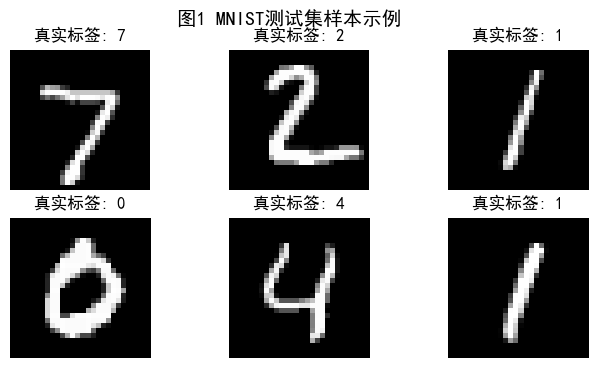

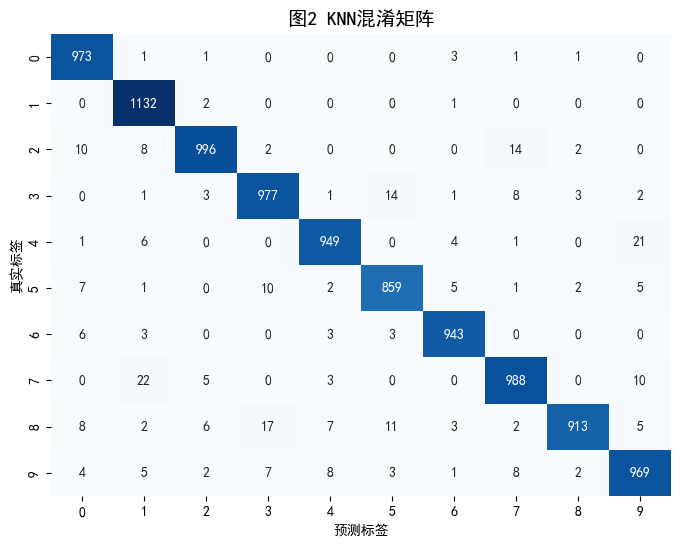

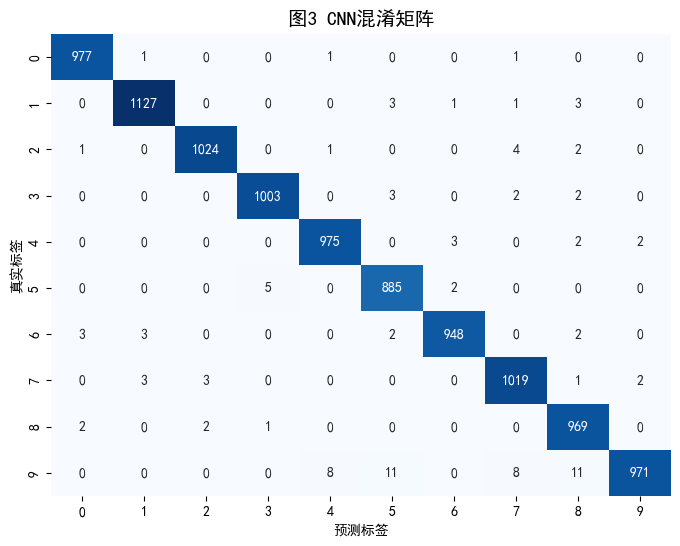

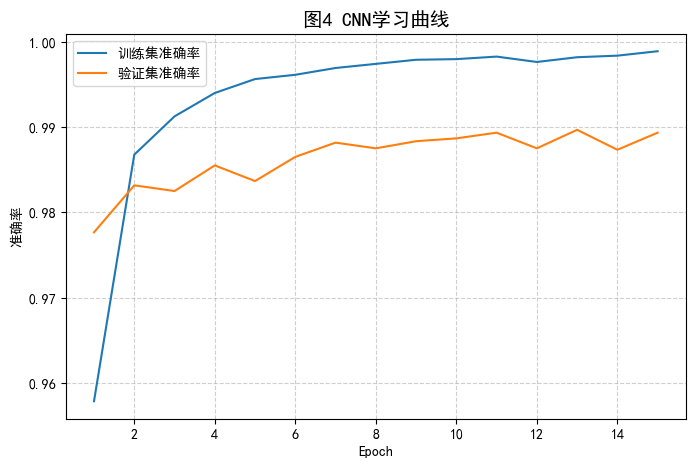

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


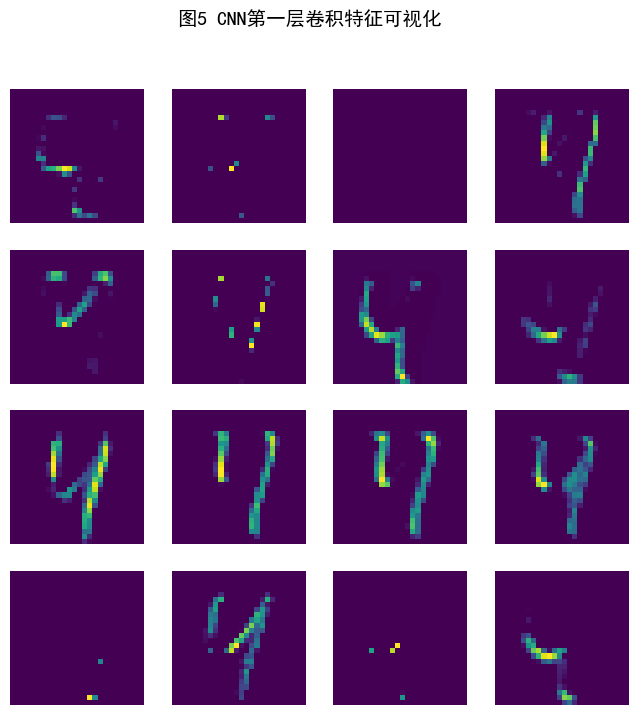

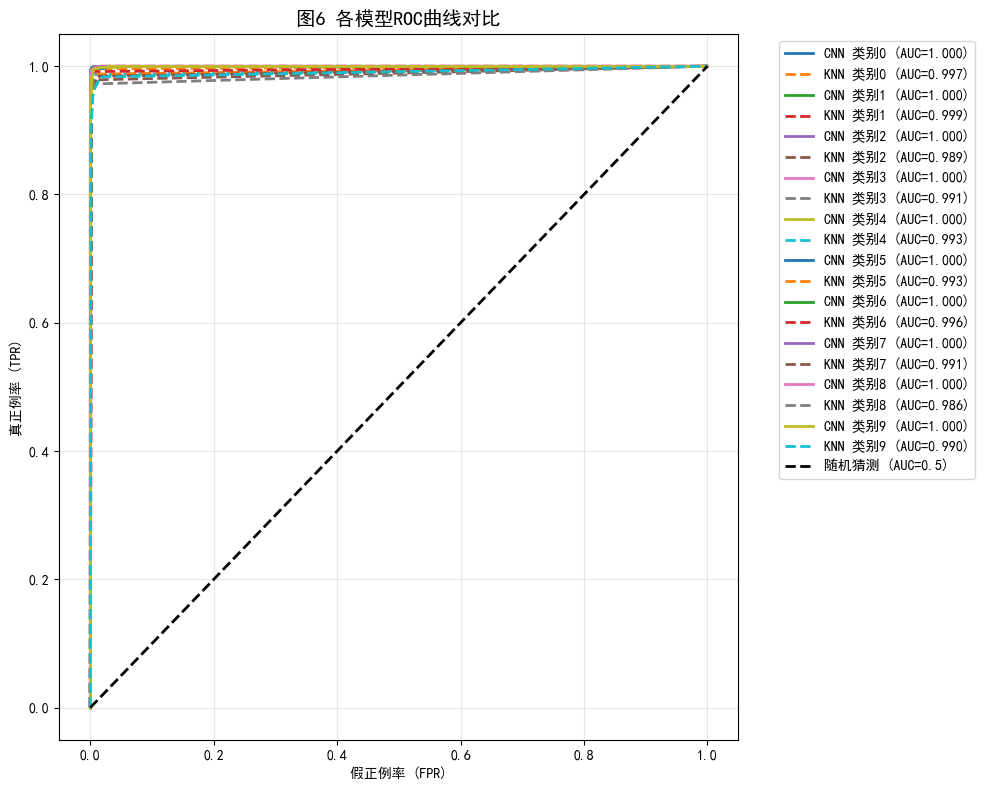

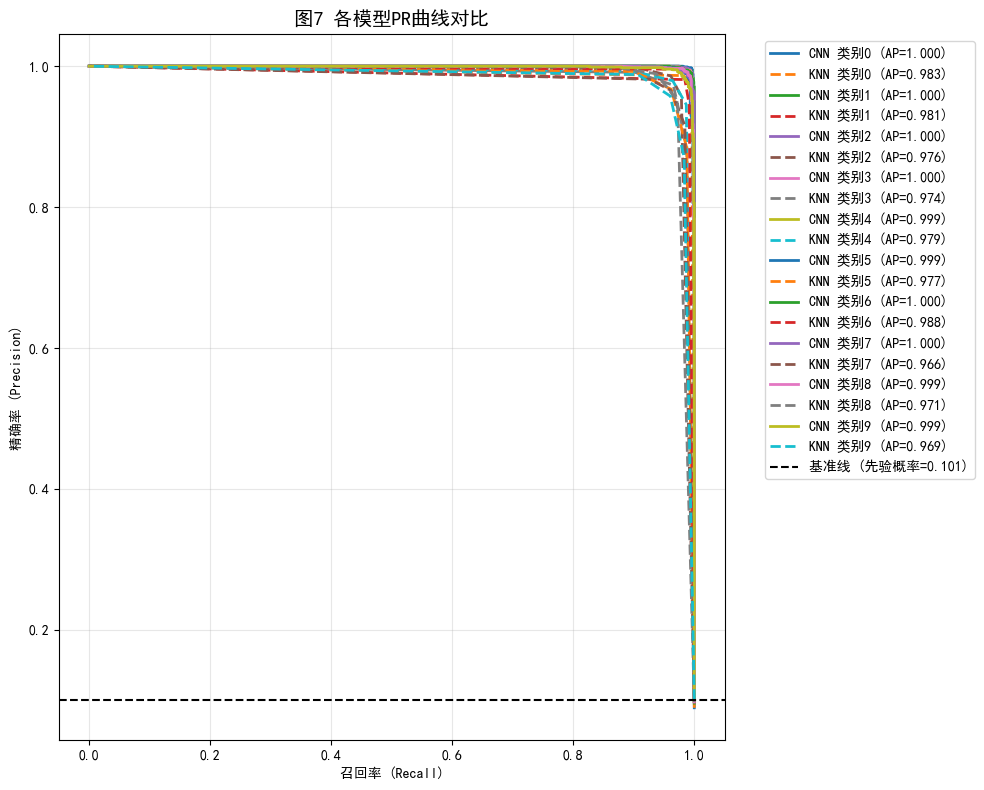

In [106]:
# 10. 可视化

# 原始数据
with np.load("mnist_preprocessed.npz", allow_pickle=True) as data:
    x_train_flat = data["x_train_flat"]
    y_train = data["y_train"]
    y_test = data["y_test"]
    x_test_cnn = data["x_test_cnn"]

# KNN 结果
with np.load("knn_results.npz", allow_pickle=True) as knn_data:
    cm_knn = knn_data["confusion_matrix"]
    y_pred_knn = knn_data["y_pred"]
    y_proba_knn = knn_data.get("y_proba", None)  # 如果没有概率则为 None

# CNN 结果
with np.load("cnn_results.npz", allow_pickle=True) as cnn_data:
    train_acc_cnn = cnn_data["train_acc"]
    val_acc_cnn = cnn_data["val_acc"]
    cm_cnn = cnn_data["confusion_matrix"]
    y_pred_cnn = cnn_data["y_pred"]

# CNN 最终完整结果
with np.load("cnn_final_complete_results.npz", allow_pickle=True) as cnn_final_data:
    cnn_test_results = cnn_final_data["test_results"].item()
    y_proba_cnn = cnn_test_results["y_pred_proba"]

# Dummy 模型结果
with np.load("dummy_results.npz", allow_pickle=True) as dummy_data:
    dummy_test_acc = dummy_data["test_acc"]

# 加载 CNN 模型
cnn = load_model("cnn_final_model.h5")

# 图1：样本示例 
plt.figure(figsize=(8, 4))
for i in range(6):
    plt.subplot(2, 3, i+1)
    img = x_test_cnn[i].reshape(28, 28)
    plt.imshow(img, cmap="gray")
    plt.title(f"真实标签: {y_test[i]}", fontsize=12)
    plt.axis("off")
plt.suptitle("图1 MNIST测试集样本示例", fontsize=14)
plt.savefig("图1_MNIST样本示例.png", dpi=300, bbox_inches="tight")
plt.show()

# 图2：KNN混淆矩阵 
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=range(10), yticklabels=range(10))
plt.title("图2 KNN混淆矩阵", fontsize=14)
plt.xlabel("预测标签")
plt.ylabel("真实标签")
plt.savefig("图2_KNN混淆矩阵.png", dpi=300, bbox_inches="tight")
plt.show()

# 图3：CNN混淆矩阵 
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=range(10), yticklabels=range(10))
plt.title("图3 CNN混淆矩阵", fontsize=14)
plt.xlabel("预测标签")
plt.ylabel("真实标签")
plt.savefig("图3_CNN混淆矩阵.png", dpi=300, bbox_inches="tight")
plt.show()

# 图4：CNN学习曲线 
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_acc_cnn)+1), train_acc_cnn, label="训练集准确率")
plt.plot(range(1, len(val_acc_cnn)+1), val_acc_cnn, label="验证集准确率")
plt.title("图4 CNN学习曲线", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("准确率")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig("图4_CNN学习曲线.png", dpi=300, bbox_inches="tight")
plt.show()

# 图5：CNN第一层卷积特征可视化
sample_idx = 42
img = x_test_cnn[sample_idx:sample_idx+1]
input_tensor = Input(shape=(28, 28, 1))
first_conv_layer = cnn.layers[0]
activation_model = Model(inputs=input_tensor, outputs=first_conv_layer(input_tensor))
activations = activation_model.predict(img)
first_layer_activation = activations[0]

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(first_layer_activation[:, :, i], cmap="viridis")
    plt.axis("off")
plt.suptitle("图5 CNN第一层卷积特征可视化", fontsize=14)
plt.savefig("图5_CNN卷积特征可视化.png", dpi=300, bbox_inches="tight")
plt.show()

# 图6：ROC曲线对比

encoder = OneHotEncoder(sparse_output=False)
y_test_onehot = encoder.fit_transform(y_test.reshape(-1, 1))

if y_proba_knn is None:
    y_proba_knn = np.zeros((len(y_test), 10))
    y_proba_knn[np.arange(len(y_test)), y_pred_knn] = 1.0

plt.figure(figsize=(10, 8))
for i in range(10):
    fpr_cnn, tpr_cnn, _ = roc_curve(y_test_onehot[:, i], y_proba_cnn[:, i])
    auc_cnn = roc_auc_score(y_test_onehot[:, i], y_proba_cnn[:, i])
    plt.plot(fpr_cnn, tpr_cnn, lw=2, label=f'CNN 类别{i} (AUC={auc_cnn:.3f})')
    fpr_knn, tpr_knn, _ = roc_curve(y_test_onehot[:, i], y_proba_knn[:, i])
    auc_knn = roc_auc_score(y_test_onehot[:, i], y_proba_knn[:, i])
    plt.plot(fpr_knn, tpr_knn, lw=2, linestyle='--', label=f'KNN 类别{i} (AUC={auc_knn:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='随机猜测 (AUC=0.5)')

plt.xlabel('假正例率 (FPR)')
plt.ylabel('真正例率 (TPR)')
plt.title('图6 各模型ROC曲线对比', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('图6_ROC曲线.png', dpi=300, bbox_inches='tight')
plt.show()

# 图7：PR曲线对比
plt.figure(figsize=(10, 8))
for i in range(10):
    precision_cnn, recall_cnn, _ = precision_recall_curve(y_test_onehot[:, i], y_proba_cnn[:, i])
    ap_cnn = average_precision_score(y_test_onehot[:, i], y_proba_cnn[:, i])
    plt.plot(recall_cnn, precision_cnn, lw=2, label=f'CNN 类别{i} (AP={ap_cnn:.3f})')
    
    precision_knn, recall_knn, _ = precision_recall_curve(y_test_onehot[:, i], y_proba_knn[:, i])
    ap_knn = average_precision_score(y_test_onehot[:, i], y_proba_knn[:, i])
    plt.plot(recall_knn, precision_knn, lw=2, linestyle='--', label=f'KNN 类别{i} (AP={ap_knn:.3f})')

# 基准线
baseline = np.sum(y_test_onehot[:, i]) / len(y_test_onehot)
plt.axhline(y=baseline, color='k', linestyle='--', label=f'基准线 (先验概率={baseline:.3f})')

plt.xlabel('召回率 (Recall)')
plt.ylabel('精确率 (Precision)')
plt.title('图7 各模型PR曲线对比', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('图7_PR曲线.png', dpi=300, bbox_inches='tight')
plt.show()


In [107]:
# 11. 消融实验

def build_cnn(learning_rate=1e-3, filters1=32, filters2=64):
    model = Sequential([
        Conv2D(filters=filters1, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=filters2, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(10, activation="softmax")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# 早停回调
early_stopping = EarlyStopping(
    monitor="val_loss",  
    patience=3,          
    restore_best_weights=True  
)

# 最优参数
best_lr = 1e-3  
best_filters1 = 64  
best_lr_py = float(best_lr)
best_filters1_py = int(best_filters1)

with np.load("mnist_preprocessed.npz", allow_pickle=True) as data:
    x_train_cnn = data["x_train_cnn"]
    x_val_cnn = data["x_val_cnn"]
    x_test_cnn = data["x_test_cnn"]
    y_train = data["y_train"]
    y_val = data["y_val"]
    y_test = data["y_test"]

cnn_final = build_cnn(learning_rate=best_lr_py, filters1=best_filters1_py)
cnn_final.fit(
    x_train_cnn, y_train,
    validation_data=(x_val_cnn, y_val),
    batch_size=32, epochs=15, callbacks=[early_stopping], verbose=1
)

# 基准模型测试
_, base_test_acc = cnn_final.evaluate(x_test_cnn, y_test, verbose=0)
print(f"\n【基准模型】测试准确率：{base_test_acc:.4f}")

# 消融实验1：不做灰度归一化
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = mnist.load_data()
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
    x_train_raw, y_train_raw,
    test_size=6000,  
    random_state=42,
    stratify=y_train_raw  
)

x_train_no_norm = x_train_split.reshape(-1, 28, 28, 1).astype(np.uint8)
x_val_no_norm = x_val_split.reshape(-1, 28, 28, 1).astype(np.uint8)
x_test_no_norm = x_test_raw.reshape(-1, 28, 28, 1).astype(np.uint8)

# 训练并测试无归一化模型
model_no_norm = build_cnn(learning_rate=best_lr_py, filters1=best_filters1_py)
model_no_norm.fit(
    x_train_no_norm, y_train_split,
    validation_data=(x_val_no_norm, y_val_split),
    batch_size=32, epochs=15, callbacks=[early_stopping], verbose=0
)
_, no_norm_acc = model_no_norm.evaluate(x_test_no_norm, y_test_raw, verbose=0)
print(f"无归一化测试准确率：{no_norm_acc:.4f}")

# 消融实验2：去掉池化层
def build_cnn_no_pooling(learning_rate=1e-3, filters1=32, filters2=64):
    model = Sequential([
        Conv2D(filters=filters1, kernel_size=(3,3), activation="relu", input_shape=(28,28,1)),
        # 去掉第一个池化层
        Conv2D(filters=filters2, kernel_size=(3,3), activation="relu"),
        # 去掉第二个池化层
        Flatten(),
        Dense(128, activation="relu"),
        Dense(10, activation="softmax")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# 使用转换后的参数训练
model_no_pool = build_cnn_no_pooling(learning_rate=best_lr_py, filters1=best_filters1_py)
model_no_pool.fit(
    x_train_cnn, y_train,
    validation_data=(x_val_cnn, y_val),
    batch_size=32, epochs=15, callbacks=[early_stopping], verbose=0
)
_, no_pool_acc = model_no_pool.evaluate(x_test_cnn, y_test, verbose=0)
print(f"去掉池化层测试准确率：{no_pool_acc:.4f}")

# 消融实验3：用全连接层替代卷积层
def build_mlp_instead(learning_rate=1e-3):
    model = Sequential([
        Flatten(input_shape=(28,28,1)),  
        Dense(256, activation="relu"),
        Dense(128, activation="relu"),
        Dense(10, activation="softmax")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# 使用转换后的参数训练
model_mlp = build_mlp_instead(learning_rate=best_lr_py)
model_mlp.fit(
    x_train_cnn, y_train,
    validation_data=(x_val_cnn, y_val),
    batch_size=32, epochs=15, callbacks=[early_stopping], verbose=0
)
_, mlp_acc = model_mlp.evaluate(x_test_cnn, y_test, verbose=0)
print(f"全连接替代卷积测试准确率：{mlp_acc:.4f}")

np.savez(
    "ablation_results.npz",
    base_acc=base_test_acc,
    no_norm_acc=no_norm_acc,
    no_pool_acc=no_pool_acc,
    mlp_acc=mlp_acc,
    best_lr=best_lr_py,  
    best_filters1=best_filters1_py
)

d:\Users\26097\Desktop\机器学习-手写数字识别\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.9601 - loss: 0.1298 - val_accuracy: 0.9783 - val_loss: 0.0729
Epoch 2/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9870 - loss: 0.0425 - val_accuracy: 0.9828 - val_loss: 0.0626
Epoch 3/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9917 - loss: 0.0270 - val_accuracy: 0.9855 - val_loss: 0.0531
Epoch 4/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9938 - loss: 0.0194 - val_accuracy: 0.9812 - val_loss: 0.0785
Epoch 5/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9956 - loss: 0.0140 - val_accuracy: 0.9763 - val_loss: 0.1054
Epoch 6/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9963 - loss: 0.0111 - val_accuracy: 0.9832 - val_loss: 0.0835

【基准模型】测试准确率：0.9888


d:\Users\26097\Desktop\机器学习-手写数字识别\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


无归一化测试准确率：0.9737
去掉池化层测试准确率：0.9838


d:\Users\26097\Desktop\机器学习-手写数字识别\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


全连接替代卷积测试准确率：0.9656


测试集样本总数：10000

cnn_final_complete_results.npz 中的所有键：['hyperparams', 'training_history', 'test_results']

共发现 102 个误判样本，索引列表：[ 62 160 320 321 359 445 448 582 619 659]...


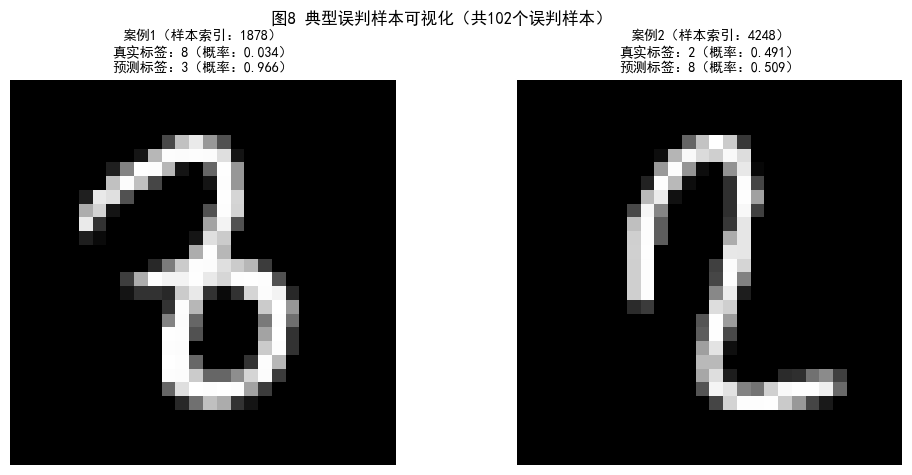


案例1详情：样本1878，真实8→预测3，概率分布：[0.    0.    0.    0.966 0.    0.    0.    0.    0.034 0.   ]
案例2详情：样本4248，真实2→预测8，概率分布：[0.    0.    0.491 0.    0.    0.    0.    0.    0.509 0.   ]


In [108]:
# 12. 误差分析

with np.load("mnist_preprocessed.npz", allow_pickle=True) as data:
    x_test_cnn = data["x_test_cnn"]
    y_test = data["y_test"]
    test_set_size = len(x_test_cnn)
print(f"测试集样本总数：{test_set_size}")

with np.load("cnn_final_complete_results.npz", allow_pickle=True) as cnn_data:
    print(f"\ncnn_final_complete_results.npz 中的所有键：{cnn_data.files}")
    cnn_test_results = cnn_data["test_results"].item()  
    y_pred_cnn = cnn_test_results["y_pred"]        
    y_pred_proba_cnn = cnn_test_results["y_pred_proba"]  

# 找到所有误判样本
misclassified_idx = np.where(y_pred_cnn != y_test)[0]
misclassified_count = len(misclassified_idx)

if misclassified_count == 0:
    print("\n未发现误判样本")
else:
    print(f"\n共发现 {misclassified_count} 个误判样本，索引列表：{misclassified_idx[:10]}...")  # 打印前10个

    if len(misclassified_idx) >= 2:
        case1_idx, case2_idx = np.random.choice(misclassified_idx, size=2, replace=False)
    else:
        case1_idx = case2_idx = misclassified_idx[0]

    # 提取案例数据
    case1_img = x_test_cnn[case1_idx].reshape(28, 28)
    case1_true = y_test[case1_idx]
    case1_pred = y_pred_cnn[case1_idx]
    case1_proba = y_pred_proba_cnn[case1_idx]  

    case2_img = x_test_cnn[case2_idx].reshape(28, 28)
    case2_true = y_test[case2_idx]
    case2_pred = y_pred_cnn[case2_idx]
    case2_proba = y_pred_proba_cnn[case2_idx]

    plt.figure(figsize=(12, 5))

    # 案例1
    plt.subplot(1, 2, 1)
    plt.imshow(case1_img, cmap="gray")
    plt.title(f"案例1（样本索引：{case1_idx}）\n"
              f"真实标签：{case1_true}（概率：{case1_proba[case1_true]:.3f}）\n"
              f"预测标签：{case1_pred}（概率：{case1_proba[case1_pred]:.3f}）",
              fontsize=10)
    plt.axis("off")

    # 案例2
    plt.subplot(1, 2, 2)
    plt.imshow(case2_img, cmap="gray")
    plt.title(f"案例2（样本索引：{case2_idx}）\n"
              f"真实标签：{case2_true}（概率：{case2_proba[case2_true]:.3f}）\n"
              f"预测标签：{case2_pred}（概率：{case2_proba[case2_pred]:.3f}）",
              fontsize=10)
    plt.axis("off")

    plt.suptitle(f"图8 典型误判样本可视化（共{misclassified_count}个误判样本）", fontsize=12, y=1.02)
    plt.savefig("图8_误判样本可视化.png", dpi=300, bbox_inches='tight')
    plt.show()

    # 打印案例详情（便于分析）
    print(f"\n案例1详情：样本{case1_idx}，真实{case1_true}→预测{case1_pred}，概率分布：{case1_proba.round(3)}")
    print(f"案例2详情：样本{case2_idx}，真实{case2_true}→预测{case2_pred}，概率分布：{case2_proba.round(3)}")